In [3]:
#!pip install miceforest --no-cache-dir

In [1]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import os.path
import time, itertools, re
from sklearn.metrics import make_scorer
import miceforest as mf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split,StratifiedGroupKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
print(os.getcwd())
fileloc_data='/'.join(os.getcwd().split('/')[0:5])+ '/data/annonymizedDatasets/'
savetag='combinedDatasets'
print(fileloc_data)
#sys.path.append('/'.join(os.getcwd().split('/')[0:4])+'/nan_smote/')
from FigPlotting import clusterPlot, plot_dendrogram
#############################################
df_main=pd.read_csv(fileloc_data+'maskedDAIsy_MainDectoolEDEQ_Visit1_Only.tsv', sep='\t', decimal=',')
print(df_main.columns)
print(df_main['pid'].nunique(), df_main['intid'].nunique())
#df_main.head(3)

/home/sreejita/ProjectsPy/GGZ/code_scripts/ED-profiling
/home/sreejita/ProjectsPy/GGZ/data/annonymizedDatasets/
Index(['intid', 'seq_num-edeq', 'EDEQscore', 'pid', 'p_startdate',
       'p_dischargedate', 'age', 'bsex', 'edu_level', 'edu_comp',
       'Highest_Edu', 'EDtype', 'icd9_code', 'icd9_lab', 'BMI', 'IND_anders',
       'IND_as_I_II_comorbiditeiten', 'IND_borderline_comorbiditeit',
       'IND_depressie_comorbiditeit', 'IND_duur_stoornis_2plus_jaar',
       'IND_eerdere_spec_behandeling_zonder_effect',
       'IND_ernstig_verstoord_eten', 'IND_extreem_laag_hoog_BMI',
       'IND_ocd_comorbiditeit', 'aantal_eerdere_trajecten',
       'andere_comorbiditeiten', 'duur_stoornis_in_jaren', 'interpretation',
       'leeftijd_invullen', 'p_dectool_invultijd', 'seq_num-dec',
       'uitslag_waarde', 'verstoord_eetpatroon', 'volgorde', 'Split'],
      dtype='object')
298 300


In [24]:
df_dec_mhcsf_sq48=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Visit1.tsv', sep='\t', decimal=',')
print(df_dec_mhcsf_sq48['pid'].nunique(),df_dec_mhcsf_sq48['intid'].nunique())
pid_per_intid=df_dec_mhcsf_sq48['pid'].value_counts()
print('PIDs repeated in INTIDs: ', pid_per_intid[pid_per_intid.values>1])
df_dec_mhcsf_sq48[['EDtype', 'Split']].value_counts()

294 296
PIDs repeated in INTIDs:  pid
461    2
530    2
Name: count, dtype: int64


EDtype            Split
Anorexia nervosa  Train    87
Bulimia nervosa   Train    40
Other ED          Train    38
Binge-ED          Train    37
Anorexia nervosa  Test     27
Others            Train    21
Bulimia nervosa   Test     13
Binge-ED          Test     13
Other ED          Test     12
Others            Test      8
Name: count, dtype: int64

In [28]:
df_lav=pd.read_csv(fileloc_data+'maskedDAIsy_LAV.tsv', sep='\t',decimal=',')
df_lav[['Split']].value_counts()

Split
Train    711
Test     141
Name: count, dtype: int64

### Correlation Matrix of the combined datasets

In [5]:
df_Question_EDEQ=pd.read_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',')
df_Question_EDEQ['aantal_eerdere_trajecten'].loc[df_Question_EDEQ['aantal_eerdere_trajecten'].isnull()]=0
df_Question_EDEQ['duur_stoornis_in_jaren'].loc[df_Question_EDEQ['duur_stoornis_in_jaren'].isnull()]=0
#df_edeq=pd.read_csv(fileloc_data+'maskedDAIsy_EDEQ_Score.tsv', sep='\t', decimal=',')
#print(df_edeq.columns)
#df_edeq['intid'] = df_edeq['intid'].astype(float)
#df_edeq_reqd=df_edeq[['intid', 'seq_num-edeq','eating', 'weight','bodyshape', 'lines']].loc[df_edeq['seq_num-edeq']==1].copy()
#df_Question_EDEQ=pd.merge(df_edeq_reqd, df_Questionnaires, on='intid', how='inner')
colsDectools=[#'uitslag_waarde', 
              'BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', #'IND_duur_stoornis_2plus_jaar', 
    'duur_stoornis_in_jaren', #'IND_as_I_II_comorbiditeiten',
    'IND_depressie_comorbiditeit','IND_borderline_comorbiditeit', 'IND_ocd_comorbiditeit', 'IND_anders','IND_ernstig_verstoord_eten']
df_Question_EDEQ.astype(dict(zip(colsDectools, ['float', 'float','float', 'float', 'float','float','float',
                                               'float','float','float','float','float']))).dtypes
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines']
df_Question_EDEQ.astype(dict(zip(colsEDEQ, ['float', 'float','float', 'float']))).dtypes
#colsEDQOL=['Psychologisch', 'FysiekCognitief','Financieel', 'WerkSchool', 'EDQOLscore']
colsHonos=['Somscore', 'Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
df_Question_EDEQ.astype(dict(zip(colsHonos, ['float', 'float','float', 'float', 'float','float']))).dtypes
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid', 'LAV_Score']
df_Question_EDEQ.astype(dict(zip(colsLAV, ['float', 'float','float', 'float']))).dtypes
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie', 'SQ48score']
df_Question_EDEQ.astype(dict(zip(colsSQ48, ['float', 'float','float', 'float', 'float','float','float',
                                               'float','float','float']))).dtypes
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB', 'mhcsf_score']
df_Question_EDEQ.astype(dict(zip(colsMHCSF, ['float', 'float','float', 'float']))).dtypes
colNames=['Main-Age', 'Main-BSex','Main-EduLevel', 'Main-ED_Codes', 'EDEQ-score','EDEQ-eating', 'EDEQ-weight', 'EDEQ-bodyshape',
'EDEQ-lines', #'DT-uitslag_waarde',
'DT-BMI', 'DT-IND_prev_spec_int_wo_eff', 'DT-num_prev_routes', #'DT-IND_Disorder_Duration_2+Yrs',
'DT-Disorder_Duration_Yrs', #'DT-IND_I_II_CMD', 
'DT-IND_depressie_CMD','DT-IND_BDL_CMD', 'DT-IND_OCD_CMD', 'DT-IND_others',
'DT-IND_VDisturbdEating', 'Honos-Somscore', 'Honos-Beperkingen','Honos-Functioneren', 'Honos-Gedragsproblemen', 
'Honos-Symptomalogie', 'Honos-SocialeProblemen','Lav-Neg_Waardering','Lav-Gebrek_Vertrouwdheid', 'Lav-Alg_Ontevredenheid', 
'Lav-Score', 'SQ48-Hostility','SQ48-Agorafobie','SQ48-Angst','SQ48-Depressie','SQ48-Cognitieve_Complain',
'SQ48-Somatische_Complain', 'SQ48-Sociale_Fobie','SQ48-Vitaliteit_Optimisme','SQ48-Werk_Studie', 'SQ48-Score', 
'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB', 'MHCSF-Score']  

df_Question_EDEQ['BMI']=df_Question_EDEQ['BMI'].astype(float)
df_Question_EDEQ['duur_stoornis_in_jaren']=df_Question_EDEQ['duur_stoornis_in_jaren'].astype(float)
df_Question_EDEQ['bsex'] = df_Question_EDEQ['bsex'].astype('category')
df_Question_EDEQ['biosex'] = df_Question_EDEQ['bsex'].cat.codes
df_Question_EDEQ['biosex']=df_Question_EDEQ['biosex'].astype(float)
df_Question_EDEQ['EDtype'] = df_Question_EDEQ['EDtype'].astype('category')
df_Question_EDEQ['ED_Codes'] = df_Question_EDEQ['EDtype'].cat.codes
df_Question_EDEQ['Highest_Edu'] = df_Question_EDEQ['Highest_Edu'].astype('category')
df_Question_EDEQ['Education'] = df_Question_EDEQ['Highest_Edu'].cat.codes
df_Question_EDEQ['Education']=df_Question_EDEQ['Education'].astype(float)
#df_Question_EDEQ.to_csv(fileloc_data+'maskedDAIsy_MainDec_ED_SQ48_MHCSF_Honos_Lav_Visit1.tsv', sep='\t', decimal=',',
#                       index=False)
df_train_explore=df_Question_EDEQ.loc[df_Question_EDEQ['Split']=='Train']
df_test_explore=df_Question_EDEQ.loc[df_Question_EDEQ['Split']=='Test']
print(df_train_explore['bsex'].value_counts())
print(df_train_explore['EDtype'].value_counts())
cols2consider=['age','biosex', 'Education','ED_Codes','EDEQscore']+colsEDEQ+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF
colRename_dict=dict(zip(cols2consider, colNames))

bsex
Vrouw    104
Man        3
Name: count, dtype: int64
EDtype
Anorexia nervosa    47
Binge-ED            19
Other ED            18
Bulimia nervosa     13
Others              10
Name: count, dtype: int64


In [20]:
df_Question_EDEQ[['Split', 'EDtype']].value_counts()

Split  EDtype          
Train  Anorexia nervosa    47
       Binge-ED            19
       Other ED            18
       Bulimia nervosa     13
       Others              10
Test   Anorexia nervosa     9
       Binge-ED             9
       Others               5
       Bulimia nervosa      4
       Other ED             4
Name: count, dtype: int64

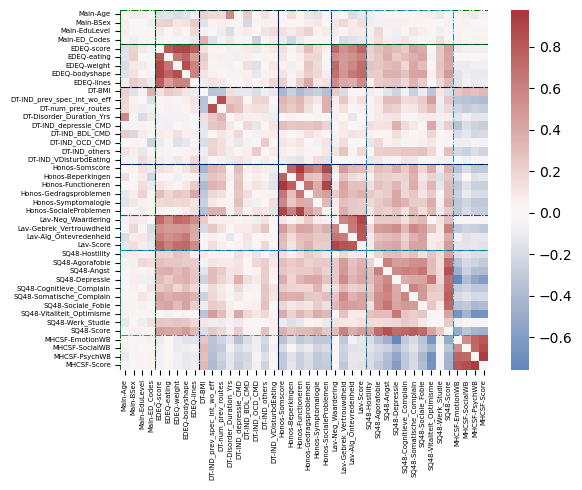

In [7]:
#df_dec_mhcsf_sq48
import matplotlib.patches as patches
#cols2consider=np.setdiff1d(cols2consider, ['EDtypes', 'bsex'])+['Edu_codes', 'ED_Codes']
cc_df_train_explore=df_train_explore[cols2consider].corr(method='spearman')
np.fill_diagonal(cc_df_train_explore.values, 0)
cc_col_dict=dict(zip(cc_df_train_explore.columns, colNames))
cc_df_train_explore.rename(columns=cc_col_dict, index=cc_col_dict, inplace=True)
fs=5
#print(df_train_explore['verstoord_eetpatroon'].value_counts())
fig0, ax0=plt.subplots(1,1,figsize=(6,5))
sns.axes_style('ticks')
#sns.set(font_scale=0.8)
sns.heatmap(cc_df_train_explore, cmap="vlag", annot=False, xticklabels=colNames, yticklabels=colNames, ax=ax0, center=0)#ax0.set_xticks(range(0, 39, 1))
ax0.tick_params(axis='x', labelrotation=90)
ax0.tick_params(axis='y', labelrotation=0)
ax0.tick_params(left=True, bottom=True)
ax0.set_xticklabels(ax0.get_xticklabels(), fontsize = fs, ha='center')
ax0.set_yticklabels(ax0.get_yticklabels(), fontsize = fs, va='center')
colors = plt.cycler("color", plt.cm.ocean(np.linspace(0, 1, 7+1)))
xy=[[0,0],[4,0],[5+len(colsEDEQ),0],[5+len(colsEDEQ)+len(colsDectools),0],[5+len(colsEDEQ)+len(colsDectools)+len(colsHonos),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48),0],
    [5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)+len(colsMHCSF),0]]
yx=[[0,0],[0,4],[0,5+len(colsEDEQ)],[0,5+len(colsEDEQ)+len(colsDectools)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)],
    [0,5+len(colsEDEQ)+len(colsDectools)+len(colsHonos)+len(colsLAV)+len(colsSQ48)+len(colsMHCSF)]]

width, height=[4, len(colsEDEQ)+1,len(colsDectools),len(colsHonos),len(colsLAV),len(colsSQ48),3.0], 44.75
for k, col in zip(range(0,6), colors):
    ax0.add_patch(patches.Rectangle(xy[k],width[k],height,edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
    ax0.add_patch(patches.Rectangle(yx[k],height,width[k],edgecolor=col["color"],fill=False,lw=0.75, linestyle='-.'))
plt.tight_layout()
plt.savefig('figs/PDFs/correlationMatrix.pdf')
plt.savefig('figs/PNGs/correlationMatrix.png')

In [8]:
n, unique_pairs = 25,[] # change this to the number of pairs you want to get
top_pairs = cc_df_train_explore.unstack().sort_values(ascending=False)[:n*2]
bottom_pairs = cc_df_train_explore.unstack().sort_values(ascending=True)[:n*2]
# Create a list to store the top pairs without duplicates
# Iterate over the top pairs and add only unique pairs to the list
for pair in top_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
top_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    top_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
unique_pairs, n=[],10
for pair in bottom_pairs.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)
# Create a dataframe with the top pairs and their correlation coefficients
bottom_pairs_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs[:n]):
    bottom_pairs_df.loc[i] = [pair[0], pair[1], cc_df_train_explore.loc[pair[0], pair[1]]]
corr_high_lows=pd.concat([top_pairs_df, bottom_pairs_df])
# Print the top pairs as a dataframe
display(corr_high_lows)

,feature_1,feature_2,corr_coef
0,Honos-Somscore,Honos-Functioneren,0.978046
1,MHCSF-Score,MHCSF-PsychWB,0.948154
2,Honos-Functioneren,Honos-SocialeProblemen,0.914491
3,EDEQ-score,EDEQ-bodyshape,0.908334
4,Lav-Neg_Waardering,Lav-Score,0.901230
5,Honos-SocialeProblemen,Honos-Somscore,0.892236
6,EDEQ-weight,EDEQ-score,0.891374
7,MHCSF-SocialWB,MHCSF-Score,0.867165
8,DT-num_prev_routes,DT-IND_prev_spec_int_wo_eff,0.860027
9,EDEQ-weight,EDEQ-bodyshape,0.858348


Correlation matrix suggests the following:
- SQ48 and MHC-SF seem to have interesting negative Spearman correlation coefficients: Discuss with Pia, Joyce, Mladena
- LAV seems to be quite highly correlated with EDEQ score: Discuss if this relation to understand why this is so
- 

### Visualizing Missing Values

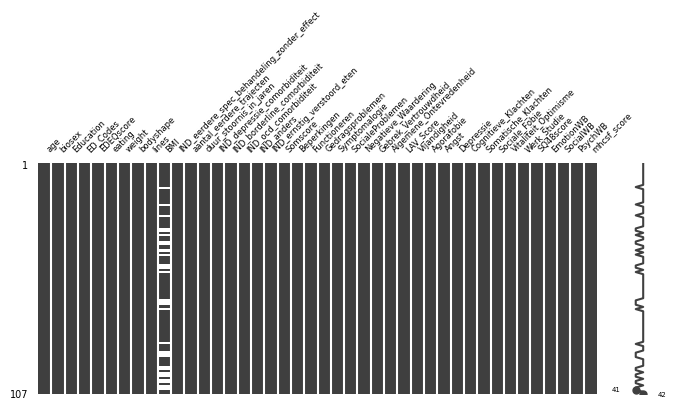

In [9]:
#!pip install missingno
import missingno as msno 
fig = msno.matrix(df_train_explore[cols2consider],figsize=(8, 3), fontsize=6)
grid_ax = fig.axes
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_NaNPatterns.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_NaNPatterns.png'%savetag)

In [10]:
colsDectools=['BMI', 'IND_eerdere_spec_behandeling_zonder_effect', 'aantal_eerdere_trajecten', #'IND_duur_stoornis_2plus_jaar', 
    'duur_stoornis_in_jaren', #'IND_as_I_II_comorbiditeiten',
    'IND_depressie_comorbiditeit', 'IND_borderline_comorbiditeit', 
    'IND_ocd_comorbiditeit', 'IND_anders','IND_ernstig_verstoord_eten']
colsEDEQ=['eating', 'weight', 'bodyshape', 'lines']
#colsEDQOL=['Psychologisch', 'FysiekCognitief','Financieel', 'WerkSchool', 'EDQOLscore']
colsHonos=['Beperkingen', 'Functioneren', 'Gedragsproblemen', 'Symptomalogie', 'SocialeProblemen']
colsLAV=['Negatieve_Waardering', 'Gebrek_Vertrouwdheid', 'Algemene_Ontevredenheid']
colsSQ48=['Vijandigheid','Agorafobie','Angst','Depressie', 'Cognitieve_Klachten','Somatische_Klachten', 'Sociale_Fobie',
          'Vitaliteit_Optimisme', 'Werk_Studie']
colsMHCSF=['EmotionWB', 'SocialWB', 'PsychWB']
cols2train=['age','biosex', 'Education']+colsDectools+colsHonos+colsLAV+colsSQ48+colsMHCSF
df_train=df_Question_EDEQ[cols2train].loc[df_Question_EDEQ['Split']=='Train'].copy()
df_test=df_Question_EDEQ[cols2train].loc[df_Question_EDEQ['Split']=='Test'].copy()

In [11]:
nan_mean=np.nanmean(df_train[cols2train].to_numpy(), axis=0)
nan_std=np.nanstd(df_train[cols2train].to_numpy(), axis=0)
z_train_explore_nan=((df_train[cols2train].to_numpy()-nan_mean)/nan_std)
z_train_df=pd.DataFrame(data=z_train_explore_nan, columns=cols2train)
kernel_mean_match = mf.ImputationKernel(data=z_train_df,num_datasets=1,mean_match_candidates=5)
kernel_mean_match.mice(10)
z_train_explore=pd.DataFrame(data=kernel_mean_match.complete_data(), columns=cols2train)
z_test_df=pd.DataFrame(data=((df_test[cols2train].to_numpy()-nan_mean)/nan_std), columns=cols2train)
z_test_explore=kernel_mean_match.impute_new_data(z_test_df)

In [12]:
z_train_explore.isnull().sum()

age                                           0
biosex                                        0
Education                                     0
BMI                                           0
IND_eerdere_spec_behandeling_zonder_effect    0
aantal_eerdere_trajecten                      0
duur_stoornis_in_jaren                        0
IND_depressie_comorbiditeit                   0
IND_borderline_comorbiditeit                  0
IND_ocd_comorbiditeit                         0
IND_anders                                    0
IND_ernstig_verstoord_eten                    0
Beperkingen                                   0
Functioneren                                  0
Gedragsproblemen                              0
Symptomalogie                                 0
SocialeProblemen                              0
Negatieve_Waardering                          0
Gebrek_Vertrouwdheid                          0
Algemene_Ontevredenheid                       0
Vijandigheid                            

#### Eigenvalue decomposition to PCA
#### PPCA

##### EVD of data $X$: steps:
1. Center $X$: $X_c= X-\hat{X}$
2. Covariance of $X_c$: $C=X_c^{T}X_c$ (This also ensures )
3. Eigenvalue decomposition of Covariance of $X_c$: $eigVal, eigVec=eig(C) $

Shape of eig vec and val (32,) (32, 32)
Shape of evd_z_train_explore (107, 3)
Shape of FA transformed data: (107, 7)
No. of intrinsic dims according to PCA:  32
(32, 32) 32.0 0.0


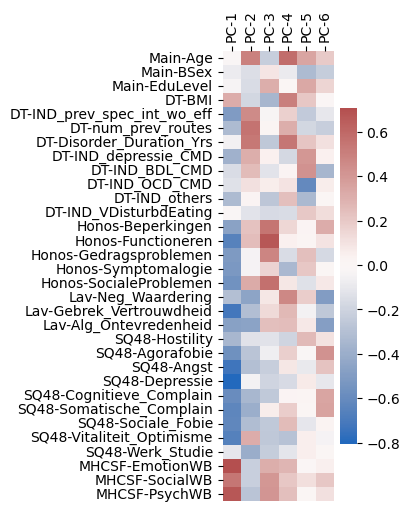

In [13]:
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.pairwise import pairwise_distances
from numpy.linalg import norm
from sklearn import metrics

#cols2train=np.setdiff1d(cols2train,['EDEQscore','ED_Codes'])
labels_true=df_train_explore['ED_Codes']#df_Questionnaires['EDtype'].loc[df_Questionnaires['Split']=='Train']
#nan_mean=np.nanmean(df_train_explore[cols2train].to_numpy(), axis=1)
#nan_std=np.nanstd(df_train_explore[cols2train].to_numpy(), axis=1)
#z_train_explore=((df_train_explore[cols2train].to_numpy().T-nan_mean)/nan_std).T
#mask=~np.isnan(z_train_explore)
#maskedarr = np.ma.array(z_train_explore, mask=~mask)
#eig_val, eig_vec=np.linalg.eig(np.ma.dot(maskedarr.T, maskedarr, mask).data)
eig_val, eig_vec=np.linalg.eig(np.dot(z_train_explore.T, z_train_explore))
print('Shape of eig vec and val', np.shape(eig_val), np.shape(eig_vec))
explained_var=np.cumsum(eig_val/np.sum(eig_val))
sind_eig_val=np.argsort(-1*(explained_var))
ndim=3
evd_z_train_explore=np.dot(z_train_explore,eig_vec[sind_eig_val[:ndim]].T)
print('Shape of evd_z_train_explore', np.shape(evd_z_train_explore))
#!pip install ppca
#from ppca import PPCA
#ppca_whole = PPCA()
#ppca_whole.fit(data=z_train_explore.to_numpy(), d=len(cols2train)-3, verbose=False)
#variance_explained, components, model_params  = ppca_whole.var_exp, ppca_whole.data, ppca_whole.C
#variance_explained2=np.cumsum(variance_explained/np.sum(variance_explained))
#components
from sklearn.decomposition import FactorAnalysis, PCA
import matplotlib as mpl
transformer = FactorAnalysis(n_components=7, random_state=0)
fa_z_train = transformer.fit_transform(z_train_explore)
print('Shape of FA transformed data:', np.shape(fa_z_train))
pca = PCA(svd_solver='full').fit(z_train_explore)
variance_explained, components=np.cumsum(pca.explained_variance_)*100/np.sum(pca.explained_variance_), pca.components_
print("No. of intrinsic dims according to PCA: ", pca.n_components_)
pca_loadings=pd.DataFrame(data=pca.components_.T * np.sqrt(pca.explained_variance_), 
                          index=z_test_df.columns, columns=['PC-'+str(x) for x in range(1,pca.n_components_+1)])
pca_loadings.rename(index=colRename_dict, inplace=True)
figPCA, axPCA=plt.subplots(1,1, figsize=(4,5), constrained_layout=True)
sns.heatmap(pca_loadings[['PC-1','PC-2','PC-3','PC-4','PC-5', 'PC-6']], ax=axPCA, xticklabels=pca_loadings.columns[:6], 
            yticklabels=pca_loadings.index, cmap='vlag', 
           center=0)
pca_loadings.sort_values(by=['PC-1','PC-2','PC-3'], ascending=[False, False, False], key=abs, inplace=True)
#pca_loadings
ymin, ymax = axPCA.get_ylim()
print(pca_loadings.shape, ymin, ymax)
axPCA.tick_params(axis='x',top=True, bottom=False, labeltop=True, labelbottom=False)
axPCA.set_xticks(np.arange(6)+0.5, labels=pca_loadings.columns[:6], rotation=90)
#axPCA.set_yticks(np.linspace(ymin, ymax, pca_loadings.shape[0]), labels=pca_loadings.index, minor=True)
axPCA.set_yticklabels(axPCA.get_yticklabels(), fontsize = fs-1, va='center', minor=True)
#axPCA.set_xticklabels('')
#axPCA.set_xticklabels(axPCA.get_xticklabels(), fontsize = fs, ha='center', minor=True)
#plt.setp(axPCA.get_xticklabels(), rotation=90, ha="right")
pca_loadings.head(3)
plt.savefig('figs/PDFs/ED_%s_PCA_loadings.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_PCA_loadings.png'%savetag)
#axPCA.set_xticklabels(axPCA.get_xticklabels(), fontsize = fs, ha='center', rotation=90)
#axPCA.set_yticklabels(axPCA.get_yticklabels(), fontsize = fs, va='center')

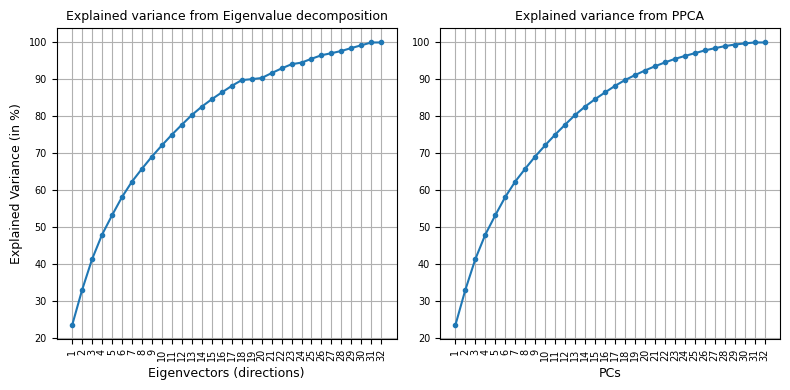

In [14]:
fs=9
f0,(a0, a1)=plt.subplots(1,2,figsize=(8, 4))# Create a scree plot to visualize the explained variance
a0.plot(range(1, len(explained_var) + 1), # x-axis
         explained_var*100, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a0.set_title('Explained variance from Eigenvalue decomposition', fontsize=fs)
a0.set_xlabel('Eigenvectors (directions)', fontsize=fs)
a0.set_ylabel('Explained Variance (in %)', fontsize=fs)
#plt.xtick
# Add label to x-axis
a0.set_xticks(range(1, len(explained_var) + 1))
a0.set_xticklabels(a0.get_xticklabels(), fontsize=fs-2, rotation=90)
a0.set_yticklabels(a0.get_yticklabels(), fontsize=fs-2)
# Add grid in the background
a0.grid(True)
a1.plot(range(1, len(variance_explained) + 1), # x-axis
         variance_explained, # convert explained variance in percentage
         marker='o',markersize=3)
# Add title and axis label
a1.set_title('Explained variance from PPCA', fontsize=fs)
a1.set_xlabel('PCs', fontsize=fs)
a1.set_ylabel('')
a1.set_xticks(range(1, len(variance_explained) + 1))
a1.set_xticklabels(a1.get_xticklabels(), fontsize=fs-2, rotation=90)
a1.set_yticklabels(a1.get_yticklabels(), fontsize=fs-2)
a1.grid()
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_PPCA.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_EVD_PPCA.pdf'%savetag)

In [15]:
print( np.shape(sind_eig_val), np.shape(labels_true), np.shape(evd_z_train_explore))

(32,) (107,) (107, 3)


In [16]:
#evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:5]].T, mask)
evd_ndim=18
evd_pdist_cos=pairwise_distances(evd_z_train_explore[:,:evd_ndim], metric='cosine')
evd_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=5,
                        ).fit(-1*evd_pdist_cos)
evd_cluster_centers_indices, evd_labels = evd_af.cluster_centers_indices_, evd_af.labels_
np.fill_diagonal(evd_pdist_cos, 0)
evd_n_clusters_ = len(evd_cluster_centers_indices)
print("Estimated number of clusters: %d" % evd_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, evd_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, evd_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, evd_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, evd_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, evd_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(evd_pdist_cos, evd_labels, metric="precomputed"))
z_df_train_explore=pd.DataFrame(z_train_explore, columns=cols2train)

Estimated number of clusters: 10
Homogeneity: 0.206
Completeness: 0.133
V-measure: 0.162
Adjusted Rand Index: 0.024
Adjusted Mutual Information: 0.060
Silhouette Coefficient: 0.518


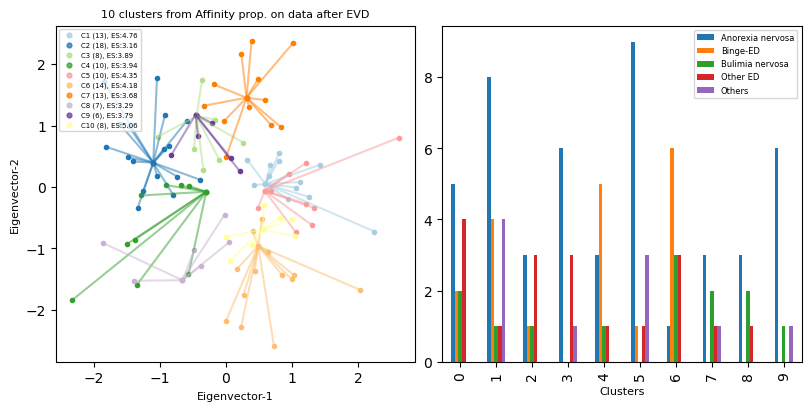

In [17]:
savetag='combinedDatasets2'
cluster_model={'model': evd_af, 'name': 'Affinity', 'pred_labels': evd_labels,
               'cluster_center_indices':evd_cluster_centers_indices}
data_tabs={'data_to_cluster': evd_pdist_cos, 'data_to_plot': evd_z_train_explore,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['EVD_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper left', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_ed_cluster_df, ed_evd_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

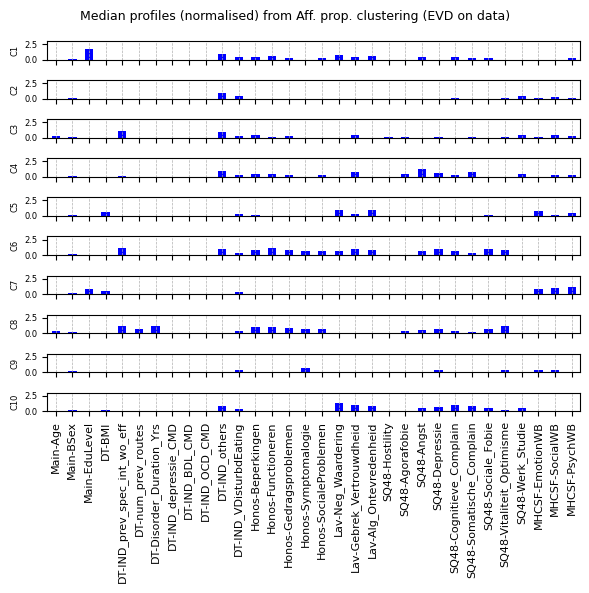

In [18]:
colNames2=['Main-Age', 'Main-BSex', 'Main-EduLevel', 'DT-BMI', 
'DT-IND_prev_spec_int_wo_eff', 'DT-num_prev_routes', #'DT-IND_Disorder_Duration_2+Yrs',
'DT-Disorder_Duration_Yrs', #'DT-IND_I_II_CMD', 
'DT-IND_depressie_CMD', 'DT-IND_BDL_CMD',
'DT-IND_OCD_CMD', 'DT-IND_others', 'DT-IND_VDisturbdEating',  'Honos-Beperkingen', 
'Honos-Functioneren', 'Honos-Gedragsproblemen', 'Honos-Symptomalogie',
'Honos-SocialeProblemen', 'Lav-Neg_Waardering', 'Lav-Gebrek_Vertrouwdheid', 
'Lav-Alg_Ontevredenheid', 'SQ48-Hostility', 'SQ48-Agorafobie', 'SQ48-Angst', 
'SQ48-Depressie', 'SQ48-Cognitieve_Complain', 'SQ48-Somatische_Complain', 
'SQ48-Sociale_Fobie', 'SQ48-Vitaliteit_Optimisme', 'SQ48-Werk_Studie', 
'MHCSF-EmotionWB', 'MHCSF-SocialWB', 'MHCSF-PsychWB']

fig31, ax31 = plt.subplots(nrows=evd_n_clusters_, ncols=1, figsize=(6,6))
#colnames=np.setdiff1d(af_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
zs_evd_ed_cluster_df.rename(columns=dict(zip(cols2train, colNames2)), inplace=True)
prof_colnames=zs_evd_ed_cluster_df.columns
for nrow in range(0,evd_n_clusters_):
    df_temp=zs_evd_ed_cluster_df.iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax31[nrow])
    ax31[nrow].set_ylim(0, 3)
    ax31[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax31[nrow].set_yticklabels(ax31[nrow].get_yticklabels(), fontsize=6)
    if nrow<evd_n_clusters_-1:        
        ax31[nrow].set_xticklabels('')
    else:
        ax31[nrow].set_xticklabels(prof_colnames, fontsize=8)    
    ax31[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig31.suptitle('Median profiles (normalised) from Aff. prop. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/PDFs/ED_%s_EVD_AP_Profiles.pdf'%savetag)
plt.savefig('figs/PNGs/ED_%s_EVD_AP_Profiles.png'%savetag)

ValueError: Length mismatch: Expected 107 rows, received array of length 9

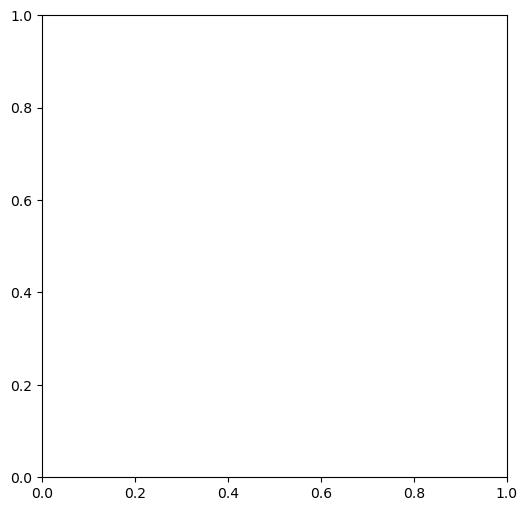

In [36]:
plot_df=df_train_explore[['age','biosex', 'Education','SQ48score', 'EDEQscore','Somscore',
                          'mhcsf_score', 'LAV_Score', 'uitslag_waarde']]
plot_df.rename(columns=dict(zip(cols2train, colNames2)), inplace=True)
prof_colnames=zs_evd_ed_cluster_df.columns
for nrow in range(0,evd_n_clusters_):
    df_temp=pd.DataFrame(data=plot_df.iloc[np.where(evd_labels==nrow)], columns=plot_df.columns)
    df_temp['Cluster']=nrow
    if nrow==0:
        df_cluster_score=df_temp
    else:
        df_cluster_score=pd.concat([df_cluster_score,df_temp])
#fig32, ax32 = plt.subplots(len(plot_df.columns),1, figsize=(6,6))
#for idx in range(0, len(plot_df.columns)):
df_cluster_score.groupby("Cluster").median()
plot(index='Cluster', columns=plot_df.columns)
#ax32[nrow].set_ylim(0, 3)
ax32.set_ylabel('C%d'%(nrow+1), fontsize=6)
ax32.set_yticklabels(ax32.get_yticklabels(), fontsize=6)
#ax32.set_xticklabels(prof_colnames, fontsize=8)    
ax32.grid(axis='x', linestyle = '--', linewidth = 0.5)
fig32.suptitle('Median profiles (normalised) from Aff. prop. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
#plt.savefig('figs/PDFs/ED_%s_EVD_AP_Profiles.pdf'%savetag)
#plt.savefig('figs/PNGs/ED_%s_EVD_AP_Profiles.png'%savetag)

Estimated number of clusters: 11
Homogeneity: 0.222
Completeness: 0.135
V-measure: 0.168
Adjusted Rand Index: 0.022
Adjusted Mutual Information: 0.058
Silhouette Coefficient: 0.537


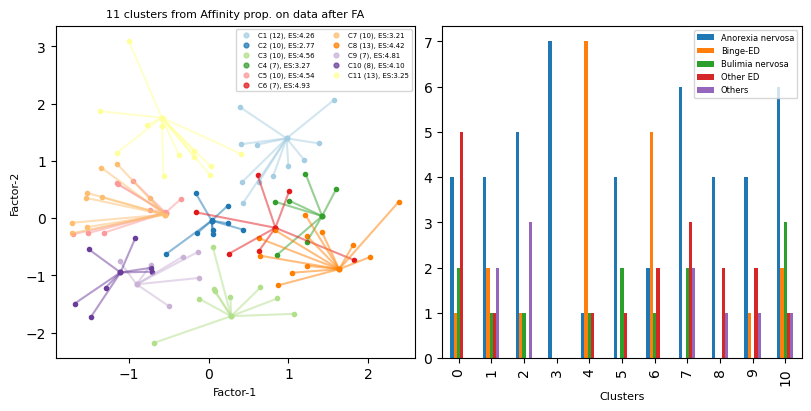

In [33]:
transformer = FactorAnalysis(n_components=3)
fa_z_train = transformer.fit_transform(z_train_explore)
fa_pdist_cos=pairwise_distances(fa_z_train, metric='cosine')
fa_af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=100, convergence_iter=5,
                        ).fit(-1*fa_pdist_cos)
fa_cluster_centers_indices, fa_labels = fa_af.cluster_centers_indices_, fa_af.labels_
np.fill_diagonal(fa_pdist_cos, 0)
fa_n_clusters_ = len(fa_cluster_centers_indices)
print("Estimated number of clusters: %d" % fa_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, fa_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, fa_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, fa_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, fa_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, fa_labels))
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(fa_pdist_cos, fa_labels, metric="precomputed"))

cluster_model={'model': fa_af, 'name': 'Affinity', 'pred_labels': fa_labels,
               'cluster_center_indices':fa_cluster_centers_indices}
data_tabs={'data_to_cluster': fa_pdist_cos, 'data_to_plot': fa_z_train,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['FA_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after FA', 'ncols':2,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}
zs_fa_ed_cluster_df, ed_fa_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

In [41]:
#ppca = PPCA()
#ppca.fit(data=z_train_explore.to_numpy(), d=20, verbose=False)
#variance_explained, components, model_params  = ppca.var_exp, ppca.data, ppca.C
#component_mat = ppca.transform()
#ppca_pdist_cos=pairwise_distances(component_mat[:,:3], metric='cosine')
component_mat=pca.transform(z_train_explore)
print(np.shape(components), np.shape(component_mat), np.shape(z_train_explore))
ndim_opts=np.array([3,5,8,10,12, 15,16, 18, 19, 20,21, 23, 25, 28, 30, 32])
sill_per_dim=[]
for ppca_ndim in ndim_opts:
    ppca_pdist_cos=pairwise_distances(component_mat[:,:ppca_ndim], metric='cosine')
    ppca_af_sill=[]
    for iter in range(0, 10):
        ppca_af = AffinityPropagation(affinity='precomputed',max_iter=50, convergence_iter=5).fit(-1*ppca_pdist_cos)
        ppca_af_sill.append(metrics.silhouette_score(component_mat[:,:ppca_ndim], ppca_af.labels_, metric="cosine"))
    print('Avg sill coeff for ndim=%d: %.3f (%.3f)'%(ppca_ndim, np.mean(ppca_af_sill), np.std(ppca_af_sill)))
    sill_per_dim.append(np.mean(ppca_af_sill))
    #/´ppca_pdist_cos
ppca_ndim=ndim_opts[np.argsort(-1*sill_per_dim)[0]]
print(ppca_ndim)
ppca_pdist_cos=pairwise_distances(component_mat[:,:ppca_ndim], metric='cosine')
ppca_af = AffinityPropagation(affinity='precomputed',max_iter=50, convergence_iter=5).fit(-1*ppca_pdist_cos)
ppca_cluster_centers_indices, ppca_labels = ppca_af.cluster_centers_indices_, ppca_af.labels_
ppca_n_clusters_ = len(ppca_cluster_centers_indices)
print("Estimated number of clusters: %d" % ppca_n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, ppca_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, ppca_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, ppca_labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, ppca_labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, ppca_labels))
np.fill_diagonal(ppca_pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(ppca_pdist_cos, ppca_labels, metric="precomputed"))

(33, 33) (107, 33) (107, 33)
Avg sill coeff for ndim=3: 0.500 (0.000)
Avg sill coeff for ndim=5: 0.391 (0.000)
Avg sill coeff for ndim=8: 0.273 (0.000)
Avg sill coeff for ndim=10: 0.248 (0.000)
Avg sill coeff for ndim=12: 0.218 (0.000)
Avg sill coeff for ndim=15: 0.200 (0.000)
Avg sill coeff for ndim=16: 0.203 (0.000)
Avg sill coeff for ndim=18: 0.198 (0.000)
Avg sill coeff for ndim=19: 0.194 (0.000)
Avg sill coeff for ndim=20: 0.172 (0.000)
Avg sill coeff for ndim=21: 0.159 (0.000)
Avg sill coeff for ndim=23: 0.162 (0.000)
Avg sill coeff for ndim=25: 0.157 (0.000)
Avg sill coeff for ndim=28: 0.154 (0.000)
Avg sill coeff for ndim=30: 0.140 (0.000)
Avg sill coeff for ndim=32: 0.141 (0.000)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
np.argsort(-1*sill_per_dim)

array([], dtype=int64)

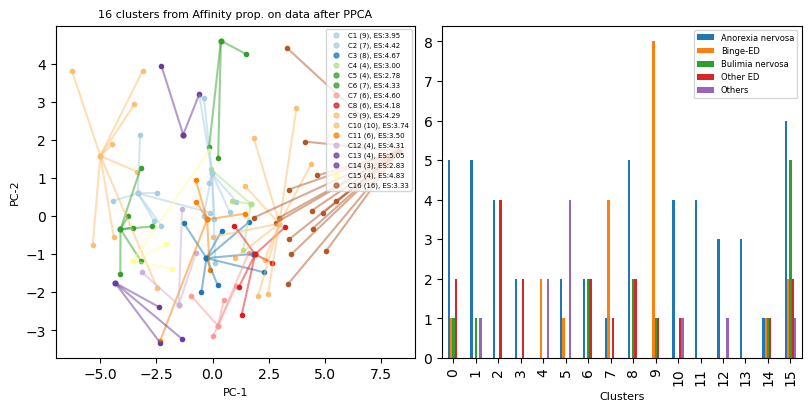

In [31]:
cluster_model={'model': ppca_af, 'name': 'Affinity', 'pred_labels': ppca_labels,
               'cluster_center_indices':ppca_cluster_centers_indices}
data_tabs={'data_to_cluster': ppca_pdist_cos, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_AP_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Affinity prop. on data after PPCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_ed_cluster_df, ed_ppca_af_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

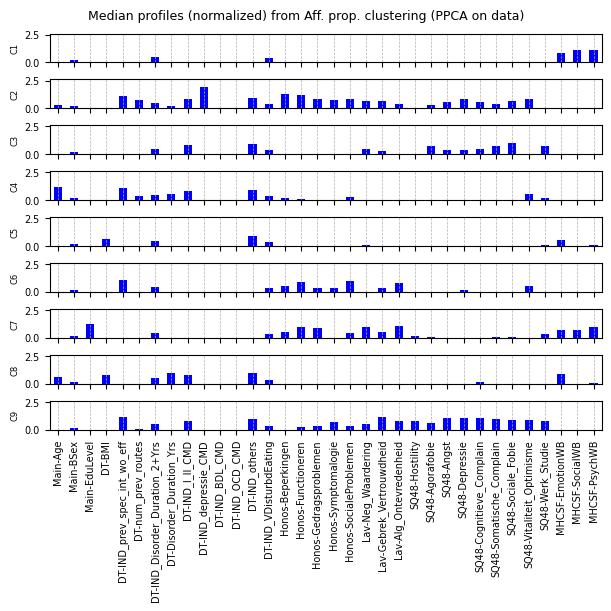

In [19]:
fig41, ax41 = plt.subplots(nrows=ppca_n_clusters_, ncols=1, layout='constrained', figsize=(6,6))
zs_ppca_ed_cluster_df.rename(columns=dict(zip(cols2train, colNames2)), inplace=True)
prof_colnames=zs_evd_ed_cluster_df.columns
#prof_colnames=zs_ppca_ed_cluster_df[cols2train].columns
for nrow in range(0,ppca_n_clusters_):
    df_temp=zs_ppca_ed_cluster_df.iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax41[nrow])
    ax41[nrow].set_ylim(0, 2.6)
    ax41[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax41[nrow].set_yticklabels(ax41[nrow].get_yticklabels(), fontsize=fs-2)
    if nrow<ppca_n_clusters_-1:        
        ax41[nrow].set_xticklabels('')
    else:
        ax41[nrow].set_xticklabels(prof_colnames, fontsize=fs-2)    
    ax41[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig41.suptitle('Median profiles (normalized) from Aff. prop. clustering (PPCA on data)', fontsize=fs)
plt.savefig('figs/PDFs/ED_c%s_PPCA_AP_Profiles.pdf'%savetag)
plt.savefig('figs/PNGs/ED_c%s_PPCA_AP_Profiles.png'%savetag)

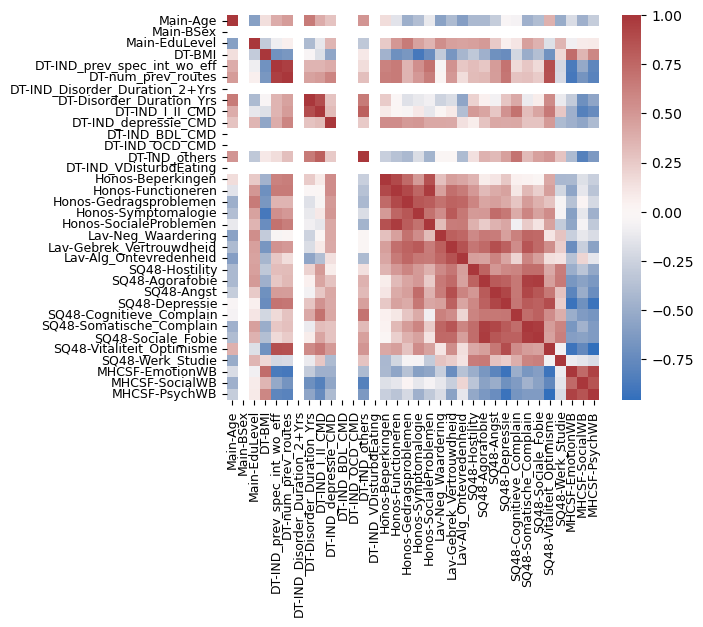

In [20]:
f,ax=plt.subplots(1,1, figsize=(6,5))
sns.axes_style('ticks')
corr_map=zs_ppca_ed_cluster_df.corr(method='spearman')
#corr_map.rename(columns=dict(zip(cols2train,colNames2)), 
#                index=dict(zip(cols2train,colNames2)),
#                inplace=True)
sns.heatmap(corr_map, cmap='vlag', xticklabels=corr_map.columns, 
            yticklabels=corr_map.columns, ax=ax, center=0)
ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='y', labelrotation=0)
ax.tick_params(left=True, bottom=True)
ax.set_xticklabels(ax.get_xticklabels(), fontsize = fs, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), fontsize = fs, va='center')
print('')

#### Trying Affinity Propagation without any dimensionality reduction (i.e., without EVD or PPCA)

In [21]:
pdist_cos = np.zeros((np.shape(z_train_explore)[0],np.shape(z_train_explore)[0]))
pdist_cos=pairwise_distances(z_train_explore, metric='cosine')
#for i in range(np.shape(z_train_explore)[0]):
#    for j in range(np.shape(z_train_explore)[0]):
        #combo_mask=mask[i]& mask[j]
#        temp_i, temp_j=z_train_explore.to_numpy()[i], z_train_explore.to_numpy()[j]
        #c_tmp = np.dot(temp_i[combo_mask], temp_j[combo_mask])/(norm(temp_i[combo_mask])*norm(temp_j[combo_mask])) 
#        c_tmp = np.dot(temp_i, temp_j)/(norm(temp_i)*norm(temp_j)) 
#        pdist_cos[i][j] = c_tmp
af = AffinityPropagation(random_state=42, affinity='precomputed',max_iter=500, convergence_iter=20).fit(-1*pdist_cos)
cluster_centers_indices, labels, n_clusters_ = af.cluster_centers_indices_, af.labels_, len(af.cluster_centers_indices_)
print("Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"% metrics.adjusted_mutual_info_score(labels_true, labels))
np.fill_diagonal(pdist_cos, 0)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(pdist_cos, labels, metric="precomputed"))

Estimated number of clusters: 18
Homogeneity: 0.413
Completeness: 0.214
V-measure: 0.282
Adjusted Rand Index: 0.046
Adjusted Mutual Information: 0.132
Silhouette Coefficient: 0.152


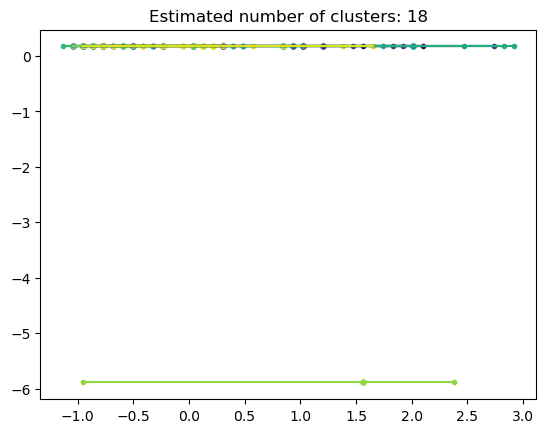

In [22]:
plt.figure(0)
colors = plt.cycler("color", plt.cm.viridis(np.linspace(0, 1, n_clusters_+1)))
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = z_train_explore.to_numpy()[cluster_centers_indices[k]]
    #cluster_center=cluster_center[cluster_centers_indices[k]]
    plt.scatter(z_train_explore.to_numpy()[class_members, 0], z_train_explore.to_numpy()[class_members, 1], 
                color=col["color"], marker=".")
    plt.scatter(cluster_center[0], cluster_center[1], s=14, color=col["color"], marker="o")
    for x in z_train_explore.to_numpy()[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], color=col["color"])
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

#### Clustering with Gaussian Mixture models

In [25]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

In [46]:
param_grid = {"n_components": range(3, 15),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
ndim=5
#evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:ndim]].T, mask)
grid_search = GridSearchCV(GaussianMixture(n_init=20, max_iter=300), param_grid=param_grid, scoring=gmm_bic_score)
#grid_search.fit(evd_z_train_explore.data)
grid_search.fit(evd_z_train_explore)
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
#sns.catplot(data=df, kind="bar", x="Number of components", y="BIC score", hue="Type of covariance",)
#plt.show()
df.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
96,3,spherical,random_from_data,212.192590
72,3,spherical,kmeans,213.733244
84,3,spherical,k-means++,214.672785
97,4,spherical,random_from_data,228.457857
85,4,spherical,k-means++,231.458802


In [23]:
#evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:3]].T, mask)
ndim=7
#evd_z_train_explore=np.ma.dot(maskedarr,eig_vec[sind_eig_val[:ndim]].T, mask)
#evd_z_train_explore=np.dot(eig_vec[sind_eig_val[:ndim]].T)
iters, n_components, data_to_cluster=5, 4, evd_z_train_explore#[:,:ndim]
#data_to_cluster.rename(columns=dict(zip(cols2train, colNames2)), inplace=True)
sill=np.zeros(iters,)
for iter in range(0,iters):
    gmm_model_try=GaussianMixture(n_init=20, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, gmm_model_try.predict(data_to_cluster), metric="cosine")
    
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
evd_gmm_model=GaussianMixture(n_init=20, max_iter=100, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans', random_state=101).fit(data_to_cluster)
evd_gmm_labels=evd_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"%(metrics.silhouette_score(data_to_cluster, evd_gmm_labels, metric="cosine")) )
evd_gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
evd_gmm_ED_cluster['GMMcluster']=evd_gmm_labels

Average silhouette Coefficient: 0.364 (0.013)
Silhouette Coefficient: 0.366


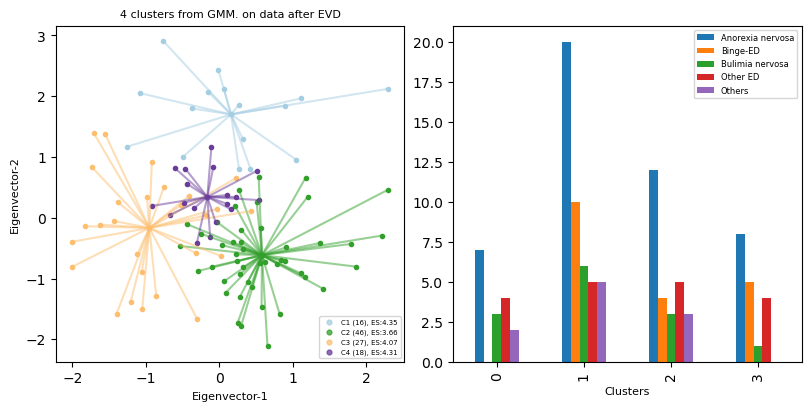

In [24]:
cluster_model={'model': evd_gmm_model, 'name': 'GMM', 'pred_labels': evd_gmm_labels}
data_tabs={'data_to_cluster':evd_z_train_explore, 'data_to_plot': evd_z_train_explore,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['EVD_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after EVD', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower right', 'ax0_xlab':'Eigenvector-1', 'ax0_ylab':'Eigenvector-2'}
zs_evd_gmm_ed_cluster_df, ed_evd_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)
zs_evd_gmm_ed_cluster_df.rename(columns=dict(zip(cols2train, colNames2)), inplace=True)

#### Prepresentative profiles of each cluster

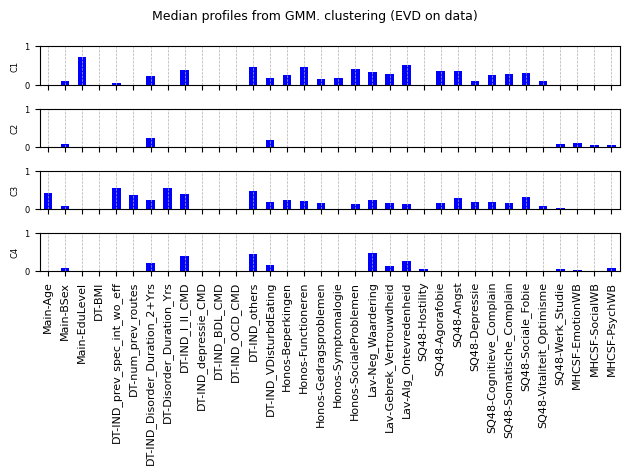

In [25]:
fig51, ax51 = plt.subplots(nrows=n_components, ncols=1)
colnames=zs_evd_gmm_ed_cluster_df.columns#np.setdiff1d(gmm_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])
for nrow in range(0,n_components):
    df_temp=zs_evd_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax51[nrow])
    ax51[nrow].set_ylim(0, 2)
    ax51[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax51[nrow].set_yticklabels(ax51[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax51[nrow].set_xticklabels('')
    else:
        ax51[nrow].set_xticklabels(colnames, fontsize=8)    
    ax51[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig51.suptitle('Median profiles from GMM. clustering (EVD on data)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/ED_%s_EVD_GMM_Profiles.pdf'%savetag)
plt.savefig('figs/ED_%s_EVD_GMM_Profiles.png'%savetag)

In [40]:
param_grid2 = {"n_components": range(3, 12),
    "covariance_type": ["diag", "full", "spherical"],
    "init_params":['kmeans','k-means++', 'random_from_data']}
ndim=3
grid_search2 = GridSearchCV(GaussianMixture(n_init=5, max_iter=300), param_grid=param_grid2, scoring=gmm_bic_score)
grid_search2.fit(component_mat[:,:ndim])
df2 = pd.DataFrame(grid_search2.cv_results_)[
    ["param_n_components", "param_covariance_type","param_init_params", "mean_test_score", ]]
df2["mean_test_score"] = -df2["mean_test_score"]
df2 = df2.rename(columns={"param_n_components": "Number of components",
"param_covariance_type": "Type of covariance", "param_init_params": "Init params", "mean_test_score": "BIC score"})
df2.sort_values(by=["BIC score"]).head()

,Number of components,Type of covariance,Init params,BIC score
54,3,spherical,kmeans,319.648700
72,3,spherical,random_from_data,321.691175
63,3,spherical,k-means++,321.696404
55,4,spherical,kmeans,338.036945
64,4,spherical,k-means++,338.160674


In [26]:
ndim=15
n_components, data_to_cluster=3, component_mat[:,:ndim]
sill=np.zeros(iters,)
for iter in range(0,iters):
    ppca_gmm_model_try=GaussianMixture(n_init=3, max_iter=200, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, ppca_gmm_model_try.predict(data_to_cluster), metric="cosine")
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
ppca_gmm_model=GaussianMixture(n_init=3, max_iter=200, n_components=n_components, 
        covariance_type='spherical', init_params='kmeans', random_state=101).fit(data_to_cluster)
ppca_gmm_labels=ppca_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, ppca_gmm_labels, metric="cosine"))
ppca_gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
ppca_gmm_ED_cluster['GMMcluster']=ppca_gmm_labels

Average silhouette Coefficient: 0.153 (0.046)
Silhouette Coefficient: 0.209


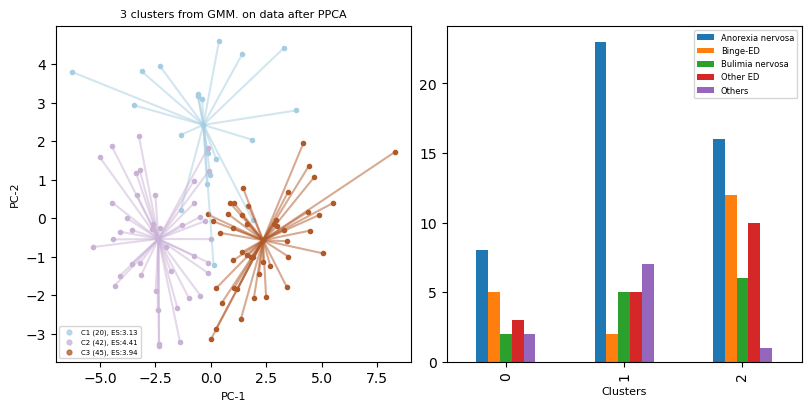

In [27]:
cluster_model={'model': ppca_gmm_model, 'name': 'GMM', 'pred_labels': ppca_gmm_labels}
data_tabs={'data_to_cluster':component_mat[:,:ndim], 'data_to_plot': component_mat[:,:ndim],'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after PPCA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_gmm_ed_cluster_df, ed_ppca_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

In [46]:
fig61, ax61 = plt.subplots(nrows=n_components, ncols=1)
zs_ppca_gmm_ed_cluster_df.rename(columns=dict(zip(columns=dict(zip(cols2train, colNames2)))))
colnames=zs_ppca_gmm_ed_cluster_df.columns
for nrow in range(0,n_components):
    df_temp=zs_ppca_gmm_ed_cluster_df[colnames].iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=ax61[nrow])
    ax61[nrow].set_ylim(0, 2)
    ax61[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    ax61[nrow].set_yticklabels(ax61[nrow].get_yticklabels(), fontsize=6)
    if nrow<n_components-1:        
        ax61[nrow].set_xticklabels('')
    else:
        ax61[nrow].set_xticklabels(colnames, fontsize=8)    
    ax61[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig61.suptitle('Median profiles (normalized) from GMM. clustering (PPCA on data)', fontsize=9)
plt.tight_layout()
savetag='combinedDatasets'
plt.savefig('figs/ED_%s_PPCA_GMM_Profiles.pdf'%(savetag))

NameError: name 'n_components' is not defined

Average silhouette Coefficient: 0.402 (0.036)
Silhouette Coefficient: 0.405


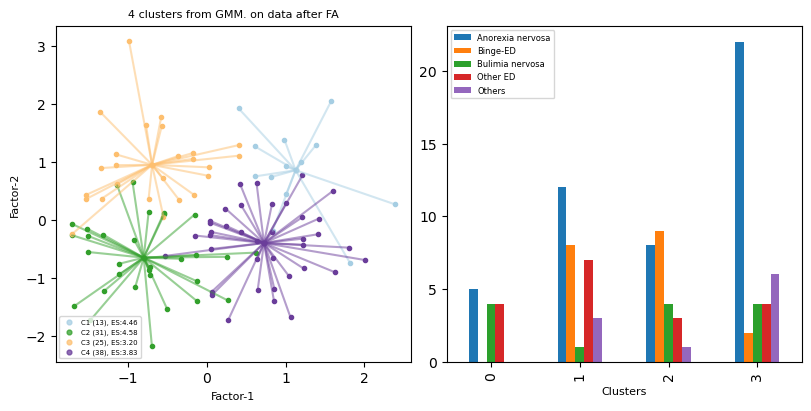

In [29]:
ndim=7
n_components, data_to_cluster=4, fa_z_train[:,:ndim]
sill=np.zeros(iters,)
for iter in range(0,iters):
    fa_gmm_model_try=GaussianMixture(n_init=3, max_iter=300, n_components=n_components, covariance_type='spherical', 
                          init_params='kmeans').fit(data_to_cluster)
    sill[iter]=metrics.silhouette_score(data_to_cluster, fa_gmm_model_try.predict(data_to_cluster), metric="cosine")
print("Average silhouette Coefficient: %0.3f (%.3f)"%(np.mean(sill), np.std(sill)) )
fa_gmm_model=GaussianMixture(n_init=3, max_iter=300, n_components=n_components, 
        covariance_type='spherical', init_params='kmeans', random_state=110).fit(data_to_cluster)
fa_gmm_labels=fa_gmm_model.predict(data_to_cluster)
print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(data_to_cluster, fa_gmm_labels, metric="cosine"))
fa_gmm_ED_cluster=df_train_explore[['EDtype', 'EDEQscore']].copy()
fa_gmm_ED_cluster['GMMcluster']=fa_gmm_labels

cluster_model={'model': fa_gmm_model, 'name': 'GMM', 'pred_labels': fa_gmm_labels}
data_tabs={'data_to_cluster':component_mat[:,:3], 'data_to_plot': data_to_cluster,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['FA_GMM_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from GMM. on data after FA', 'ncols':1,
               'fs': 8, 'legend_loc': 'lower left', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}
zs_fa_gmm_ed_cluster_df, ed_fa_gmm_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

#### Agglomerative clustering

In [30]:
from sklearn.cluster import AgglomerativeClustering
data_to_cluster, linkage, diss=ppca_pdist_cos, 'complete', 'precomputed'
sill_coef=np.zeros((5,11))
for idx,n_comp in enumerate(range(2,13)):
    for iter in range(0,5):
        try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity=diss, linkage=linkage).fit(data_to_cluster)
        sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric=diss)
    print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))

if np.argsort(-1*np.mean(sill_coef,axis=0))[0]>2:
    ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[0]+2
else:
    ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[1]+2
agg_clust=AgglomerativeClustering(n_clusters=ncomp, affinity=diss, linkage=linkage).fit(data_to_cluster)
agg_labels=agg_clust.fit_predict(data_to_cluster)

Silhouette Coefficient of 2 clusters: 0.419 (0.000)
Silhouette Coefficient of 3 clusters: 0.338 (0.000)
Silhouette Coefficient of 4 clusters: 0.333 (0.000)
Silhouette Coefficient of 5 clusters: 0.327 (0.000)
Silhouette Coefficient of 6 clusters: 0.375 (0.000)
Silhouette Coefficient of 7 clusters: 0.397 (0.000)
Silhouette Coefficient of 8 clusters: 0.351 (0.000)
Silhouette Coefficient of 9 clusters: 0.417 (0.000)
Silhouette Coefficient of 10 clusters: 0.400 (0.000)
Silhouette Coefficient of 11 clusters: 0.415 (0.000)
Silhouette Coefficient of 12 clusters: 0.430 (0.000)


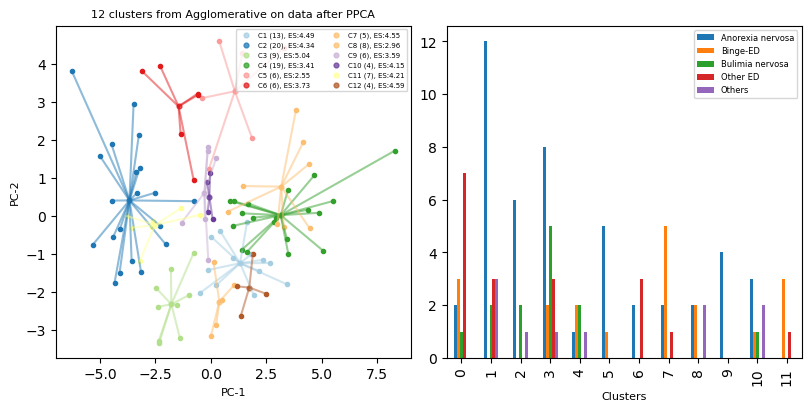

In [31]:
#from scipy.cluster import hierarchy
cluster_model={'model': agg_clust, 'name': 'Agglomerative', 'pred_labels':agg_labels}
data_tabs={'data_to_cluster':ppca_pdist_cos, 'data_to_plot': component_mat,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['PPCA_Agglom_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Agglomerative on data after PPCA', 'ncols':2,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'PC-1', 'ax0_ylab':'PC-2'}
zs_ppca_agg_ed_cluster_df, ed_ppca_agg_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

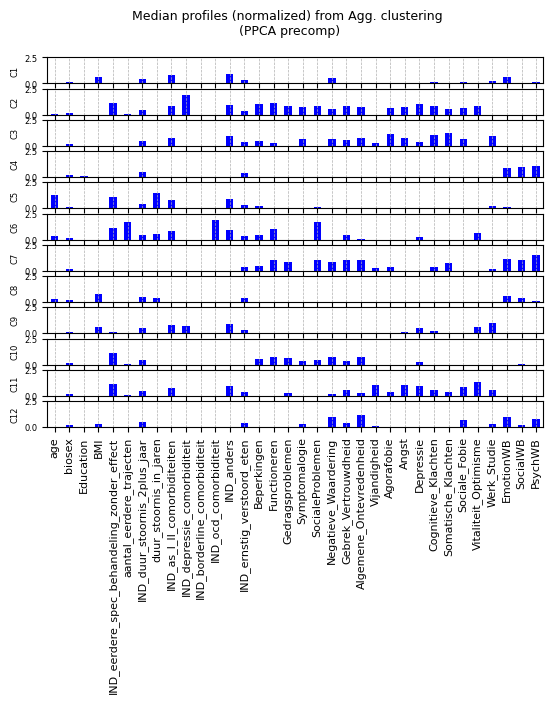

In [32]:
fig8, axes8 = plt.subplots(nrows=ncomp, ncols=1)
colnames=zs_ppca_agg_ed_cluster_df.columns
for nrow in range(0,ncomp):
    df_temp=zs_ppca_agg_ed_cluster_df.iloc[nrow]
    df_temp.plot.bar(legend=False, color='blue', rot=90, ax=axes8[nrow])
    axes8[nrow].set_ylim(0, 2.5)
    axes8[nrow].set_ylabel('C%d'%(nrow+1), fontsize=6)
    axes8[nrow].set_yticklabels(axes8[nrow].get_yticklabels(), fontsize=6)
    if nrow<ncomp-1:        
        axes8[nrow].set_xticklabels('')
    else:
        axes8[nrow].set_xticklabels(colnames, fontsize=8)    
    axes8[nrow].grid(axis='x', linestyle = '--', linewidth = 0.5)
fig8.suptitle('Median profiles (normalized) from Agg. clustering\n (PPCA precomp)', fontsize=9)
plt.tight_layout()
plt.savefig('figs/ED_%s_PPCA_Agg_Clust_Profiles.pdf'%savetag)
plt.savefig('figs/ED_%s_PPCA_Agg_Clust_Profiles.png'%savetag)
    #agg_cluster_df[np.setdiff1d(agg_cluster_df.columns,['Edu_codes','ED_Codes', 'biosex'])].loc[
    #agg_cluster_df['Cluster']==nrow+1].plot(ax=axes8[nrow], kind='bar')

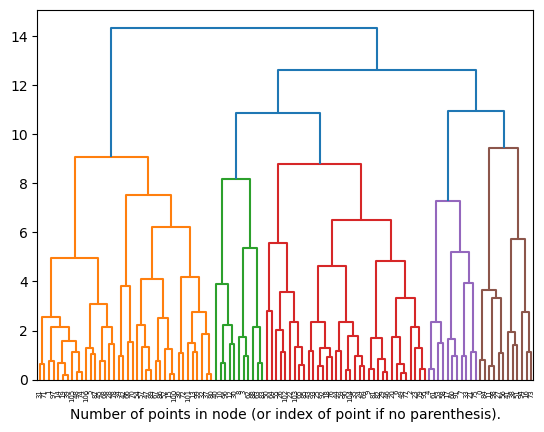

In [33]:
from scipy.cluster.hierarchy import dendrogram, linkage
#plot_dendrogram(agg_clust, truncate_mode="level", p=3)
Z=linkage(data_to_cluster, method='complete')
dendrogram(Z)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [34]:
data_to_cluster, linkage, diss=fa_z_train, 'complete', 'euclidean'
sill_coef=np.zeros((5,11))
for idx,n_comp in enumerate(range(2,13)):
    for iter in range(0,5):
        try_agg_clust=AgglomerativeClustering(n_clusters=n_comp, affinity=diss, linkage=linkage).fit(data_to_cluster)
        sill_coef[iter, idx]=metrics.silhouette_score(data_to_cluster,try_agg_clust.fit_predict(data_to_cluster), metric=diss)
    print("Silhouette Coefficient of %d clusters: %0.3f (%0.3f)"%(n_comp, np.mean(sill_coef[:,idx]), np.std(sill_coef[:,idx])))

if np.argsort(-1*np.mean(sill_coef,axis=0))[0]>2:
    ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[0]+2
else:
    ncomp=np.argsort(-1*np.mean(sill_coef,axis=0))[1]+2
agg_clust_fa=AgglomerativeClustering(n_clusters=ncomp, affinity=diss, linkage=linkage, compute_distances=True).fit(data_to_cluster)
fa_agg_labels=agg_clust_fa.fit_predict(data_to_cluster)

Silhouette Coefficient of 2 clusters: 0.153 (0.000)
Silhouette Coefficient of 3 clusters: 0.140 (0.000)
Silhouette Coefficient of 4 clusters: 0.190 (0.000)
Silhouette Coefficient of 5 clusters: 0.193 (0.000)
Silhouette Coefficient of 6 clusters: 0.202 (0.000)
Silhouette Coefficient of 7 clusters: 0.196 (0.000)
Silhouette Coefficient of 8 clusters: 0.208 (0.000)
Silhouette Coefficient of 9 clusters: 0.218 (0.000)
Silhouette Coefficient of 10 clusters: 0.213 (0.000)
Silhouette Coefficient of 11 clusters: 0.213 (0.000)
Silhouette Coefficient of 12 clusters: 0.224 (0.000)


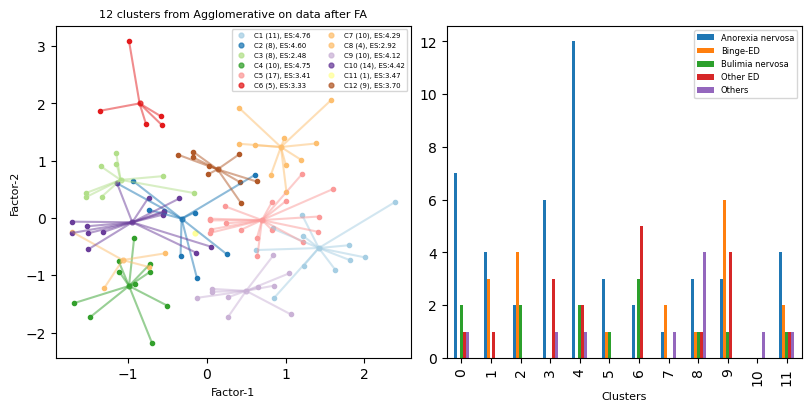

In [35]:
cluster_model={'model': agg_clust_fa, 'name': 'Agglomerative', 'pred_labels':fa_agg_labels}
data_tabs={'data_to_cluster':fa_z_train, 'data_to_plot': fa_z_train,'df': df_train_explore,
          'z_df': z_df_train_explore, 'cols2train': cols2train}
fig_naming=['FA_Agglom_Clustering', savetag]
fig_lab_titles={'fig_title': 'clusters from Agglomerative on data after FA', 'ncols':2,
               'fs': 8, 'legend_loc': 'upper right', 'ax0_xlab':'Factor-1', 'ax0_ylab':'Factor-2'}
zs_fa_agg_ed_cluster_df, ed_fa_agg_df=clusterPlot(cluster_model, data_tabs, fig_naming, fig_lab_titles)

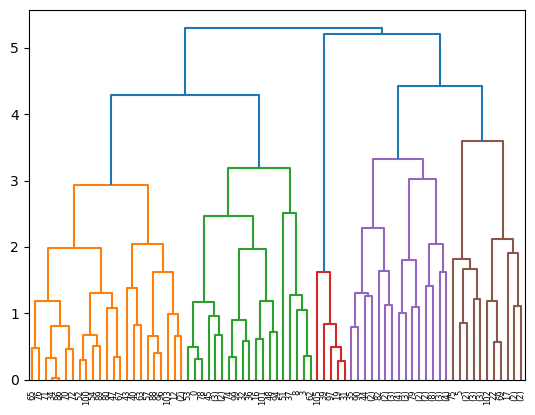

In [36]:
plot_dendrogram(agg_clust_fa, truncate_mode="level", p=6)

Computing coclust modularity for a range of cluster numbers =
 2 ...
 3 ...
 4 ...
 5 ...
 6 ...
 7 ...
 All done !
[0 1 4] [0 1 4]


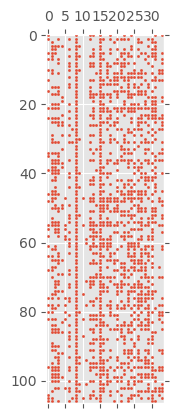

In [110]:
from coclust.io.data_loading import load_doc_term_data
from coclust.visualization import (plot_reorganized_matrix, plot_cluster_top_terms, plot_max_modularities)
from coclust.evaluation.internal import best_modularity_partition
from coclust.coclustering import CoclustMod
from scipy import sparse
# read data
X = np.matrix(z_train_explore.to_numpy())
# get the best co-clustering over a range of cluster numbers
clusters_range = range(2, 8)
model, modularities = best_modularity_partition(X, clusters_range, n_rand_init=1)
print(np.unique(model.row_labels_), np.unique(model.column_labels_))
#print(modularities)
plot_reorganized_matrix(X, model)
# plot the modularities over the range of cluster numbers
#plot_max_modularities(modularities, clusters_range)

4 54
28 48
0 0
0 0
2 5
0 0


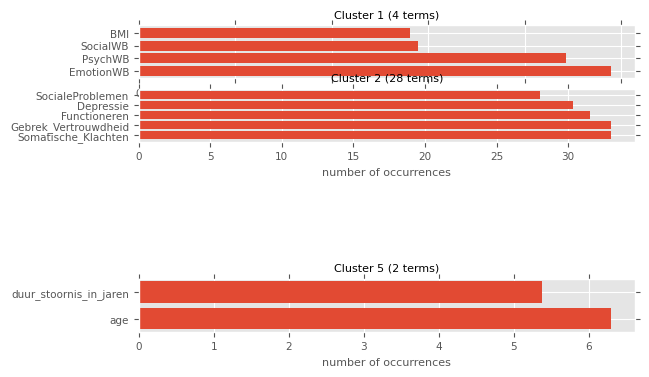

In [119]:
#### 
number_of_subplots=model.n_clusters
all_terms, nb_top_terms=z_train_explore.columns,5
x_label='number of occurrences'
for i, v in enumerate(range(number_of_subplots)):
        # Get the row/col indices corresponding to the given cluster
    row_indices, col_indices = model.get_indices(v)
    print(len(col_indices), len(row_indices))
   # print(i,v)
        # Get the submatrix corresponding to the given cluster   
    if (len(col_indices)==0) & (len(row_indices)==0):
        continue
    else:
        cluster = model.get_submatrix(X, v)
        # Count the number of each term    
        p = cluster.sum(0)
        t = p.getA().flatten()
        tmp_terms = np.array(all_terms)[col_indices]
        # Get the first n terms
        max_indices = t.argsort()[::-1][:nb_top_terms]  
        if len(col_indices)>=nb_top_terms:
            pos = np.arange(nb_top_terms)               
        else:
            pos = np.arange(len(col_indices))
    #print(pos, t)
    v = v + 1
    ax1 = plt.subplot(number_of_subplots, 1, v)
    ax1.barh(pos, t[max_indices])
    ax1.set_title("Cluster %d (%d terms)" % (v, len(col_indices)), size=8)    
    plt.yticks(pos, tmp_terms[max_indices], size=7.5)
    ax1.set_xticklabels(ax1.get_xticklabels(), size=7.5)
    plt.xlabel(x_label, size=8)
    plt.margins(y=0.05)
    # _remove_ticks()
    plt.tick_params(axis='both', which='both', bottom='on', top='off',
                    right='off', left='off')


In [103]:
print(np.shape(cluster), len(col_indices), len(row_indices))

(48, 28) 0 0
